In [1]:
!pip install transformers==3.3.1

In [2]:
import pandas as pd
train = pd.read_csv('/content/Constraint_English_Train - Sheet1.csv',#delimiter=',',
                 header=None,names=['id','tweet','label'])
train = train.drop(columns='id')
train= train[1:]
train.label = train.label.apply({'fake':0,'real':1}.get)
train.head(10) 

,tweet,label
1,The CDC currently reports 99031 deaths. In gen...,1
2,States reported 1121 deaths a small rise from ...,1
3,Politically Correct Woman (Almost) Uses Pandem...,0
4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
5,Populous states can generate large case counts...,1
6,"Covid Act Now found ""on average each person in...",1
7,If you tested positive for #COVID19 and have n...,1
8,Obama Calls Trump’s Coronavirus Response A Cha...,0
9,"???Clearly, the Obama administration did not l...",0
10,Retraction—Hydroxychloroquine or chloroquine w...,0


In [3]:
test=pd.read_csv('/content/english_test_with_labels - Sheet1.csv')
test.label = test.label.apply({'fake':0,'real':1}.get)
test

,id,tweet,label
0,1,Our daily update is published. States reported...,1
1,2,Alfalfa is the only cure for COVID-19.,0
2,3,President Trump Asked What He Would Do If He W...,0
3,4,States reported 630 deaths. We are still seein...,1
4,5,This is the sixth time a global health emergen...,1
...,...,...,...
2135,2136,#CoronaVirusUpdates: State-wise details of Tot...,1
2136,2137,Tonight 12(midnight) onwards Disaster Manageme...,0
2137,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,1
2138,2139,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,1


In [4]:
val = pd.read_csv('/content/Constraint_English_Test - Sheet1.csv')
val = val.drop(columns='id')
#val = val[1:]
val['label']=test['label']
val

,tweet,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1
...,...,...
2135,#CoronaVirusUpdates: State-wise details of Tot...,1
2136,Tonight 12(midnight) onwards Disaster Manageme...,0
2137,296 new cases of #COVID19Nigeria; Plateau-85 E...,1
2138,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,1


In [5]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [6]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (6420, 2)
validation set size: (2140, 2)


In [7]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.label.values),
                                                  train.label.values)
class_weights

array([1.04901961, 0.95535714])

In [8]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweet.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [9]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [11]:
albert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('albert-base-v2')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [13]:
model = RFClassifier(2)
model = model.to(device)

In [14]:

EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-uncased.bin')
    best_accuracy = val_acc

Epoch: 02 | Epoch Time: 2m 58s
Train Loss 0.13074233058946605 accuracy 0.9630841121495327
Val Loss 0.11298934506502614 accuracy 0.9649532710280374

Epoch: 03 | Epoch Time: 2m 58s
Train Loss 0.08908478785028208 accuracy 0.9780373831775702
Val Loss 0.15755414885795438 accuracy 0.9626168224299065

Epoch: 04 | Epoch Time: 2m 57s
Train Loss 0.044786603766000035 accuracy 0.9892523364485982
Val Loss 0.16508397907487798 accuracy 0.9616822429906542

Epoch: 05 | Epoch Time: 2m 57s
Train Loss 0.01996717521855932 accuracy 0.9959501557632399
Val Loss 0.1479277822389719 accuracy 0.9738317757009346

Epoch: 06 | Epoch Time: 2m 58s
Train Loss 0.0077335545691819075 accuracy 0.9984423676012462
Val Loss 0.18116968225317645 accuracy 0.9719626168224299

Epoch: 08 | Epoch Time: 2m 58s
Train Loss 0.0017281352880871878 accuracy 0.9996884735202493
Val Loss 0.2013352718747242 accuracy 0.9705607476635515

Epoch: 09 | Epoch Time: 2m 58s
Train Loss 0.0015816366122178363 accuracy 0.9996884735202493
Val Loss 0.202508

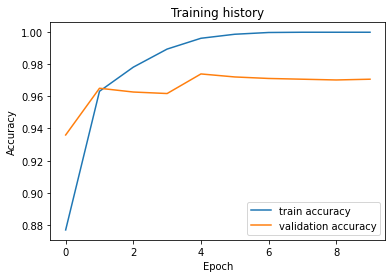

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [20]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9705607476635515

In [21]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [22]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [23]:
class_name = ['fake','real']

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

              precision    recall  f1-score   support

        fake       0.97      0.97      0.97      1020
        real       0.97      0.97      0.97      1120

    accuracy                           0.97      2140
   macro avg       0.97      0.97      0.97      2140
weighted avg       0.97      0.97      0.97      2140



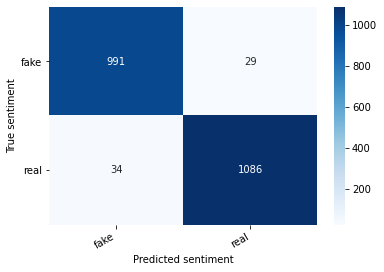

In [25]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:
#df=pd.DataFrame({'id': val.id, 'label': y_pred})
#df.label = df.label.apply({0:'fake', 1: 'real'}.get)
#df

,id,label
1,1,fake
2,2,real
3,3,fake
4,4,real
5,5,fake
...,...,...
2136,2136,real
2137,2137,real
2138,2138,fake
2139,2139,real


In [ ]:
#df.to_csv('Albert_submissionn.csv',index=False)

In [26]:
#from google.colab import files
#files.download("Albert_submissionn.csv")